In [1]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import itertools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pytorch_lightning.callbacks import ModelSummary
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from pytorch_lightning.loggers import CSVLogger
import pandas as pd
import datetime
import torch
import torch.nn as nn
from torchmetrics import Metric
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader 
import pytorch_lightning as pl
from datetime import datetime
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchmetrics import Accuracy
import logging
import os
logging.getLogger("lightning").addHandler(logging.NullHandler())
logging.getLogger("lightning").propagate = False
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
import random

seed = 42

In [2]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1, color="black")
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2, linestyle='dashed', color="grey")   
    plt.legend()
    plt.show()
    
def set_random_seeds():
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(0)

In [3]:
x_scaler = None
y_scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    
    global x_scaler
    global y_scaler
    
    #x_scaler = StandardScaler()
    #y_scaler = StandardScaler()
    # scaler = MinMaxScaler()
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    
    
    train = pd.read_csv("../data/ML-CUP22-INTERNAL-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-INTERNAL-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)

    x_test = test.iloc[:, :9].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 9:].to_numpy().astype(np.float64) 
    # x_test_blind = test.to_numpy().astype(np.float64)
    
    # x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=7)
    
    if scale:
        x_scaler.fit(x_train)
        x_train = x_scaler.transform(x_train)
        x_test = x_scaler.transform(x_test)
        
        y_scaler.fit(y_train)
        y_train = y_scaler.transform(y_train)
        y_test = y_scaler.transform(y_test)
        
        
    return x_train, y_train, x_test, y_test #, x_test_blind
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [4]:
class History:
    def __init__(self):
        self.history = {}


class LinearLearningRateScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_init, lr_final, epochs, last_epoch=-1):
        self.lr_init = lr_init
        self.lr_final = lr_final
        self.epochs = epochs
        super().__init__(optimizer, last_epoch=last_epoch)
    
    def step(self):
        self.last_epoch += 1
        epoch = self.last_epoch
        if epoch < self.epochs:
            alpha = epoch / self.epochs
            lr = self.lr_init * (1 - alpha) + alpha*self.lr_final
        else:
            lr = self.lr_final
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
            
    

def get_activation_function(name):
    if name == "relu":
        return nn.ReLU()
    elif name == "tanh":
        return nn.Tanh()
    elif name == "sigmoid":
        return nn.Sigmoid()
    elif name == "linear":
        return None

def mee(y_true, y_pred):
    return (y_true - y_pred).square().sum(axis=1).sqrt().mean()

def mse(y_true, y_pred):
    return (y_true - y_pred).square().sum(axis=1).mean()
    
    
class MEE(Metric):
    
    def __init__(self):
        super().__init__()
        self.add_state("result", default=torch.tensor(0.0))
        
    def update(self, y_pred, y_true):
        self.result += mee(y_true, y_pred)

    def compute(self):
        return self.result
    

class MultiLayerPerceptron(pl.LightningModule):
    def __init__(self, input_dim, output_dim, config):
        super(MultiLayerPerceptron, self).__init__()
        
        task = config["task"]
        self.lr = config["learning_rate"]
        self.momentum = config["momentum"]
        self.nesterov = config["nesterov"]
        init = config["initialization"]
        reg_method = config["regularization"]["method"]
        self.reg_method = reg_method
        self.lr_decay = config["learning_rate_decay"]        
        
        
        if reg_method != None:
            value = config["regularization"]["value"]
            self.reg_value = value
        
        self.task = task
        self.model = nn.Sequential()
                
        units = config["units_1"]
        activation = get_activation_function(config["activations_1"])
        
        self.model.add_module("linear_input", nn.Linear(input_dim, units))
        self.model.add_module("activations_1", activation)
        
        n_layers = 0
        for key in config.keys():
            if key.startswith("units_"):
                n_layers += 1
                
        for n_layer in range(2, n_layers+1):
            out_units = config[f"units_{n_layer}"]
            self.model.add_module(f"linear_{n_layer}", nn.Linear(units, out_units))
            activation = get_activation_function(config[f"activations_{n_layer}"])
            if activation != None:
                self.model.add_module(f"activations_{n_layer}", activation)
            units = out_units
        
        if task == "classification":
            self.model.add_module("layer_output", nn.Linear(units, output_dim))
            self.model.add_module("activations_output", nn.Sigmoid())
            self.metric = Accuracy()
            self.metric_name = "accuracy"
        
        if task == "regression":
            self.model.add_module("layer_output", nn.Linear(units, output_dim))
            self.metric = MEE()
            self.metric_name = "mee"
            
            
        self.loss = nn.MSELoss()
        self.dicts = []
                    
        if init["type"] == "uniform":
            self.min = init["min"]
            self.max = init["max"]
            for name, param in self.model.named_parameters():
                if 'weight' in name:
                    nn.init.uniform_(param, self.min, self.max)
                if 'bias' in name:
                    nn.init.uniform_(param, self.min, self.max)

            
        elif init["type"] == "normal":
            self.mean = init["mean"]
            self.std = init["std"]
            for name, param in self.model.named_parameters():
                if 'weight' in name:
                    nn.init.normal_(param, self.mean, self.std)
                if 'bias' in name:
                    nn.init.normal_(param, self.mean, self.std)
            
            

    def init_weights_uniform(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.uniform_(m.weight, self.min, self.max)
            torch.nn.init.uniform_(m.bias, self.min, self.max)
            # m.bias.data.fill_(0.01)
        
            

    def init_weights_normal(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.normal_(m.weight, self.mean, self.std)
            torch.nn.init.normal_(m.bias, self.mean, self.std)
            # m.bias.data.fill_(0.01)
            
            
    def compute_metric(self, y_pred, y_true):
        if self.task == "classification":
            y_pred = y_pred.reshape(y_true.shape)  
            return self.metric(y_pred, y_true.to(torch.int32))
        elif self.task == "regression":
            y_true = y_true.to(torch.float32)
            return self.metric(y_pred, y_true)


    def compute_loss(self, y_pred, y_true):
        if self.task == "classification":
            y_pred = y_pred.reshape(y_true.shape)  
            return self.loss(y_pred, y_true)
        elif self.task == "regression":
            y_true = y_true.to(torch.float32)
            return self.loss(y_pred, y_true)
        
        
    def get_regularization_term(self):
        
        if self.reg_method != None:
            
            value = self.reg_value
            p = 1 if self.reg_method == "l1" else 2
            reg = 0
            
            for param in self.model.parameters():
                reg += torch.linalg.norm(param, p)
                
            reg *= value
            
            return reg
        
        return 0
            
        
        
    def forward(self, x):
        return self.model(x)

    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, momentum=self.momentum, nesterov=self.nesterov)
        if self.lr_decay != None:
            decay_epochs = self.lr_decay["epochs"]
            lr_final = self.lr_decay["lr_final"]
            lr_init = self.lr
            scheduler = LinearLearningRateScheduler(optimizer, lr_init, lr_final, decay_epochs)
            return [optimizer], [scheduler]
            
        return optimizer
    
    
    

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch 
        y_copy = y # Integer y for the accuracy
        X = X.type(torch.float32)
        y = y.type(torch.float32)  
        # forward pass
        y_pred = self.forward(X)
        # accuracy
        acc = self.compute_metric(y_pred, y_copy)
        # compute loss
        reg = self.get_regularization_term()
        loss = self.compute_loss(y_pred, y) + reg
        self.log_dict({'loss': loss, f'{self.metric_name}': acc}, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    
    
    def validation_step(self, validation_batch, batch_idx):
        X, y = validation_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X)
        # compute metrics 
        acc = self.compute_metric(y_pred, y)
        # compute loss
        loss = self.compute_loss(y_pred, y)
        self.log_dict({'val_loss': loss, f'val_{self.metric_name}': acc}, prog_bar=True, logger=True)
        return loss
    
    
    
    
    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X)
        # compute metrics 
        acc = self.compute_metric(y_pred, y)
        # compute loss
        loss = self.compute_loss(y_pred, y)
        self.log_dict({'test_loss': loss, f'test_{self.metric_name}': acc}, on_epoch=True,on_step=False, prog_bar=True, logger=True)
        return loss

    
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val


def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged

def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("task")
    keys.remove("initialization")
    keys.remove("early_stopping")
    keys.remove("regularization")
    keys.remove("nesterov")
    keys.remove("trials_train")
    keys.remove("hidden_layers")
    keys.remove("trials_final")
    keys.remove("learning_rate_decay")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["early_stopping"] = params["early_stopping"]
        dict_conf["task"] = params["task"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_final"] = params["trials_final"]
        dict_conf["nesterov"] = params["nesterov"]
        dict_conf["learning_rate_decay"] = params["learning_rate_decay"]
        
        # add regularization parameters
        for reg in params["regularization"]:
            method = reg["type"]
            
            if method == None:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": None
                }
                configurations.append(reg_dict_conf)
                continue
            
            for val in reg["value"]:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": method,
                    "value": val
                }
        
                configurations.append(reg_dict_conf)
            
        
    return configurations


def get_callbacks(config):
    early_stopping = config["early_stopping"]
    callbacks = []
    
    if early_stopping != None:        
        early_stop = EarlyStopping(
            monitor=early_stopping["monitor"],
            min_delta=early_stopping["delta"],
            patience=early_stopping["patience"], 
            verbose=False,
            mode="min"
        )
        
        callbacks.append(early_stop)
        
    return callbacks if callbacks != [] else None
        


def get_layers_configurations(params, configurations):
    
    layers_list = params["hidden_layers"]
        
    layers_params_confs = []
    
    for layers in layers_list:
        
        layers_conf = {}
        
        for i in range(len(layers)):
            
            units, activation = layers[i]
            
            layers_conf[f"units_{i+1}"] = units
            layers_conf[f"activations_{i+1}"] = activation
            
        layers_params_confs.append(layers_conf)
        
    
    new_configurations = []
    
    
    for conf in configurations:
        
        for layers_conf in layers_params_confs:
            
            new_conf = conf
            new_conf.update(layers_conf)
            new_configurations.append(new_conf)
            
    
    
    
    '''layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))'''
                
    return new_configurations



def get_configurations(params):
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    return layers_confs


def get_model(config, input_size, output_size):
    model = MultiLayerPerceptron(input_size, output_size, config)
    return model
    
    
    
def fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size, metric, config):  
    
    if batch_size is None:
        batch_size_train = x_train.shape[0]
        batch_size_val = x_val.shape[0]
    else:
        batch_size_train = batch_size
        batch_size_val = batch_size
        
    
    
    train_loader = DataLoader(dataset = CustomDataset(x_train, y_train), batch_size=batch_size_train)
    validation_loader = DataLoader(dataset = CustomDataset(x_val, y_val), batch_size=batch_size_val)
    
    callbacks = get_callbacks(config)
        
    trainer = pl.Trainer(accelerator='cpu', devices=1, max_epochs=max_epochs,
                         log_every_n_steps=1, logger=CSVLogger(save_dir="logs/"),
                         callbacks=callbacks, enable_progress_bar=False,
                         enable_model_summary=False
                        )  
    
    
    trainer.fit(model=model, train_dataloaders=train_loader,
                val_dataloaders=validation_loader) 
    
    metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
    

    history = History()
            
    history.history["loss"] = metrics["loss"].dropna().to_list()
    history.history["val_loss"] = metrics["val_loss"].dropna().to_list()
    history.history[f"{metric}"] = metrics[f"{metric}"].dropna().to_list()
    history.history[f"val_{metric}"] = metrics[f"val_{metric}"].dropna().to_list()
    
    return history
    
    
    
def fit_model_k_fold(x_train, y_train, config, n_folds):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    
    trials = config["trials_train"]
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"\nExecuting fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                
                
                
                model = get_model(config, input_size, output_size)
                history = fit(model, x_train_fold, y_train_fold, x_val_fold, y_val_fold, 
                              max_epochs, batch_size, train_metric, config)
                
                trial_train_loss = history.history["loss"]
                trial_val_loss = history.history["val_loss"]         
                trial_train_acc = history.history[train_metric]
                trial_val_acc = history.history[val_metric]

                trials_val_loss.append(trial_val_loss[-1])
                trials_train_loss.append(trial_train_loss[-1])
                trials_val_acc.append(trial_val_acc[-1])
                trials_train_acc.append(trial_train_acc[-1])

                pbar.update(1)
            
        # get the mean metrics among the trials
        # med_idx = median_index(trials_val_loss)
        # med_val_loss = trials_val_loss[med_idx]
        # med_train_loss = trials_train_loss[med_idx]
        # med_val_acc = trials_val_acc[med_idx]
        # med_train_acc = trials_train_acc[med_idx]
        med_val_loss = np.mean(trials_val_loss)
        med_train_loss = np.mean(trials_train_loss)
        med_val_acc = np.mean(trials_val_acc)
        med_train_acc = np.mean(trials_train_acc)
        std_val_loss = np.std(trials_val_loss)
        std_train_loss = np.std(trials_train_loss)
        std_val_acc = np.std(trials_val_acc)
        std_train_acc = np.std(trials_train_acc)

        print(f"Fold {fold}/{n_folds} mean val_loss: {med_val_loss}, std val_loss {std_val_loss}")
        print(f"Fold {fold}/{n_folds} mean train_loss: {med_train_loss}, std train_loss {std_train_loss}")
        print(f"Fold {fold}/{n_folds} mean {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
        print(f"Fold {fold}/{n_folds} mean train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    std_train_loss = np.std(train_losses)
    std_val_loss = np.std(val_losses)
    std_train_acc = np.std(train_accs)
    std_val_acc = np.std(val_accs)
    
    print(f"\nMean val_loss: {mean_val_loss}, std val_loss: {std_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}, std train_loss: {std_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}, std train_{train_metric}: {std_train_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
        
        
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True, stratify=stratify)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
        
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
            history = fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size, train_metric, config)  

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
                                    
            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            
            pbar.update(1)
    
    # get the median metrics among the trials
    med_val_loss = np.mean(trials_val_loss)
    med_train_loss = np.mean(trials_train_loss)
    med_val_acc = np.mean(trials_val_acc)
    med_train_acc = np.mean(trials_train_acc)
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)

    print(f"\nMean val_loss: {med_val_loss}, std val_loss {std_val_loss}")
    print(f"Mean train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Mean {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
    print(f"Mean train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
    
    
    return med_val_loss
    
    

def fit_final_model(x_train, y_train, config):
    global y_scaler
    
    task = config["task"]
    trails = config["trials_final"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    val_loss = "val_mse"
    train_loss = "mse"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    trials = config["trials_final"]
    
    '''if config["early_stopping"]["monitor"] == "val_loss":
        config["early_stopping"]["monitor"] = "loss"'''
        
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
    
    trials_history_val_loss = []
    trials_history_train_loss = []
    trials_history_val_acc = []
    trials_history_train_acc = []
    
    models = []
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=stratify)
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            
            model = get_model(config, input_size, output_size)
            torch.save(model, f"./../models/pytorch_model_{trial}.pt")
            history = fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size, train_metric, config)

            models.append(model)

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]

            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            

            trials_history_val_loss.append(trial_val_loss)
            trials_history_train_loss.append(trial_train_loss)
            trials_history_val_acc.append(trial_val_acc)
            trials_history_train_acc.append(trial_train_acc)
            

            print(f"Trial {trial+1}/{trials} {val_loss}: {trial_val_loss[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_loss}: {trial_train_loss[-1]}")
            print(f"Trial {trial+1}/{trials} {val_metric}: {trial_val_acc[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc[-1]}")

            pbar.update(1)
        
    # get the mean metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian {val_loss}: {med_val_loss}, std {val_loss}: {std_val_loss}")
    print(f"Median train_{train_loss}: {med_train_loss}, std train_{train_loss}: {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric}: {std_train_acc}")
        
    
        
    train_acc = trials_history_train_acc[med_idx]
    val_acc = trials_history_val_acc[med_idx]
    
    train_loss = trials_history_train_loss[med_idx]
    val_loss = trials_history_val_loss[med_idx]
    
    
    med_model = models[med_idx]
    
    
    if task == "regression":
        
        
        y_pred = model(torch.from_numpy(x_train).to(torch.float32))
        # y_val = y_val.detach().numpy()
        
        y_pred = y_scaler.inverse_transform(y_pred.detach().numpy())
        y_train  = y_scaler.inverse_transform(y_train)
        
        y_pred  = torch.from_numpy(y_pred).to(torch.float32)
        y_train  = torch.from_numpy(y_train).to(torch.float32)
        
        mse_train = mse(y_train, y_pred)
        mee_train = mee(y_train, y_pred)

        print(f"\nTraining MSE: {mse_train}")
        print(f"Training MEE: {mee_train}")
        
        y_pred = model(torch.from_numpy(x_val).to(torch.float32))
        # y_val = y_val.detach().numpy()
        
        y_pred = y_scaler.inverse_transform(y_pred.detach().numpy())
        y_val  = y_scaler.inverse_transform(y_val)
        
        y_pred  = torch.from_numpy(y_pred).to(torch.float32)
        y_val  = torch.from_numpy(y_val).to(torch.float32)
        
        mse_val = mse(y_val, y_pred)
        mee_val = mee(y_val, y_pred)

        print(f"\nValidation MSE: {mse_val}")
        print(f"Validation MEE: {mee_val}")
    
    
    for trial in range(trials):
        if trial != med_idx:
            os.system(f"rm ./../models/pytorch_model_{trial}.pt")
            
    os.system(f"mv ./../models/pytorch_model_{med_idx}.pt ./../models/pytorch_model.pt")
    
    plot_curves(train_acc, f"Training {train_metric}", val_acc, f"Validation {val_metric}")
    plot_curves(train_loss, "Train loss", val_loss, "Validation loss")
    
    
    return med_model

    
def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss

    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:
        
        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, validation={"type": "hold-out", "val_split": 0.2}):
    set_random_seeds()
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    model = fit_final_model(x_train, y_train, best_conf)
    
    return model

# ML Cup

In [6]:
x_train, y_train, _, _ = load_dataset("cup", True)
print(x_train.shape, y_train.shape)

(1194, 9) (1194, 2)


In [7]:
params = {
    "task": "regression",
    "trials_train": 1,
    "trials_final": 5,
    "initialization": {
        "type": "default",
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.01
    },
    "max_epochs": [500],
    "learning_rate": [0.5],
    "batch_size": [16],
    "nesterov": False,
    "momentum": [0.1],
    "learning_rate_decay": {
        "epochs": 100,
        "lr_final": 0.01
    },
    "regularization": [
        {
            "type": "l1",
            "value": [0.001]
        }
    ],
    "hidden_layers": [ 
        [(20, "tanh"), (20, "relu"), (20, "tanh")],
    ]
}



k_fold_val = {
    "type": "k-fold",
    "n_folds": 4
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

Testing configuration 1/1:
{'batch_size': 16, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 20, 'activations_1': 'tanh', 'units_2': 20, 'activations_2': 'relu', 'units_3': 20, 'activations_3': 'tanh'}


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.62s/it]



Mean val_loss: 0.1108412966132164, std val_loss 0.0
Mean train_loss: 0.1080730110406875, std train_loss 0.0
Mean val_mee: 0.3494839072227478, std val_mee 0.0
Mean train_mee: 0.3261127471923828, train_mee 0.0






Best configuration (loss 0.1108412966132164):
{'batch_size': 16, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.1, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.01}, 'regularization': {'method': 'l1', 'value': 0.001}, 'units_1': 20, 'activations_1': 'tanh', 'units_2': 20, 'activations_2': 'relu', 'units_3': 20, 'activations_3': 'tanh'}


 20%|█████████                                    | 1/5 [00:17<01:11, 17.81s/it]

Trial 1/5 val_mse: 0.110705092549324
Trial 1/5 train_mse: 0.0755818784236908
Trial 1/5 val_mee: 0.3502000272274017
Trial 1/5 train_mee: 0.2649009227752685


 40%|██████████████████                           | 2/5 [00:45<01:09, 23.33s/it]

Trial 2/5 val_mse: 0.0972209200263023
Trial 2/5 train_mse: 0.0734815895557403
Trial 2/5 val_mee: 0.3285162150859833
Trial 2/5 train_mee: 0.259486049413681


 60%|███████████████████████████                  | 3/5 [01:02<00:41, 20.88s/it]

Trial 3/5 val_mse: 0.107246495783329
Trial 3/5 train_mse: 0.0792573243379592
Trial 3/5 val_mee: 0.3449641764163971
Trial 3/5 train_mee: 0.2695054709911346


 80%|████████████████████████████████████         | 4/5 [01:18<00:18, 18.66s/it]

Trial 4/5 val_mse: 0.1058548688888549
Trial 4/5 train_mse: 0.075400710105896
Trial 4/5 val_mee: 0.3490879833698272
Trial 4/5 train_mee: 0.2645285129547119


100%|█████████████████████████████████████████████| 5/5 [01:32<00:00, 18.43s/it]

Trial 5/5 val_mse: 0.1270584613084793
Trial 5/5 train_mse: 0.0862867459654808
Trial 5/5 val_mee: 0.3768595159053802
Trial 5/5 train_mee: 0.2865728139877319

Median val_mse: 0.107246495783329, std val_mse: 0.009785951535578439
Median train_mse: 0.0792573243379592, std train_mse: 0.004544681780592607
Median val_mee: 0.3449641764163971, std val_mee: 0.015551142879489515
Median train_mee: 0.2695054709911346, std train_mee: 0.009342067981527868

Training MSE: 3.968019723892212
Training MEE: 1.6063047647476196

Validation MSE: 5.307694911956787
Validation MEE: 1.8031814098358154


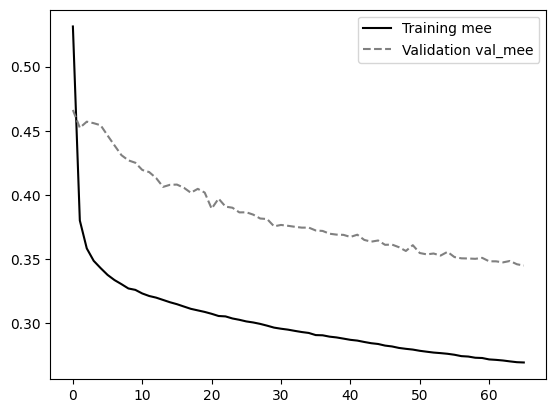

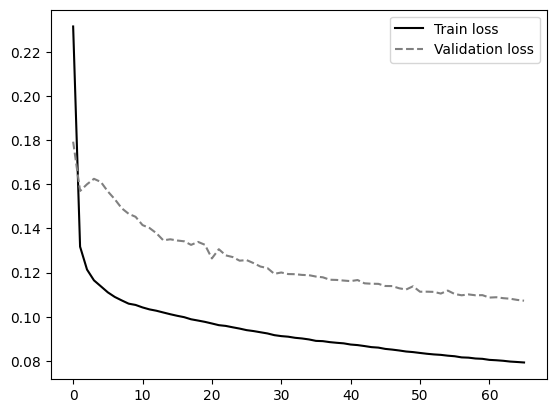

In [8]:
model = grid_search(params, x_train, y_train, hold_out_val)